In [1]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

In [2]:
def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

In [3]:
df = pd.read_csv('../sat.trn',header=None,sep = '\s')

X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()

# 7-> 6 and 1-6 -> 0:5
y[y==7] = 6
for i in range(6):
    y[y == (i + 1)] = i
    
numbers = [*range(6)]
list_y = y.tolist()
digits_indexes = []
for digit in numbers:
    li = [i for i in range(len(list_y)) if list_y[i] == digit]
    print(digit, len(li))

0 1072
1 479
2 961
3 415
4 470
5 1038


In [4]:
def get_winner(class1, class2):
    
    numbers = [*range(6)] # number 2 > number 1
    number_of_classification = 2

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])


    class1_indexes = []
    class2_indexes = []

    for i in numbers:
        if i == class1:
            class1_indexes.extend(digits_indexes[i])
        elif i == class2:
            class2_indexes.extend(digits_indexes[i])

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("number of class1:{}".format(len(class1_label)))
    print("number of class2:{}".format(len(class2_label)))

    samplesize = len(class1_label) + len(class2_label)
    x_inputs =[tuple(c) for c in X[class1_indexes].tolist()] + [tuple(c) for c in X[class2_indexes].tolist()]
    x_outputs = [tuple([c]) for c in class1_label + class2_label]
    
    
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)

            outputs = []
            for xi in x_inputs:
                output = net.activate(xi)
                outputs.append(output)


            px_outputs = softmax(np.array(outputs).reshape(samplesize, 2), axis=1)
            # the index of maximum in each line
            pred_outputs = np.argmax(px_outputs, axis = 1)
            real_outputs = np.array(x_outputs).reshape(samplesize,)

            acc = np.sum(pred_outputs == real_outputs)/samplesize

            genome.fitness = acc

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, 1)

        return [stats, winner]
    
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "../config-feedforward-satellite2")
    [stats, winner] = run(config_path)
    
    return winner

In [5]:
winner_list = []

for class1 in range(0,5):
    for class2 in range(class1+1,6):
        winner = get_winner(class1, class2)
        winner_list.append(winner)

number of class1:1072
number of class2:479

 ****** Running generation 0 ****** 

Population's average fitness: 0.39623 stdev: 0.18844
Best fitness: 0.94649 - size: (2, 7) - species 5 - id 152
Average adjusted fitness: 0.385
Mean genetic distance 2.817, standard deviation 0.505
Population of 199 members in 19 species
Total extinctions: 0
Generation time: 3.873 sec
number of class1:1072
number of class2:961

 ****** Running generation 0 ****** 

Population's average fitness: 0.48121 stdev: 0.05665
Best fitness: 0.87359 - size: (2, 7) - species 7 - id 60
Average adjusted fitness: 0.319
Mean genetic distance 3.006, standard deviation 0.515
Population of 199 members in 24 species
Total extinctions: 0
Generation time: 4.923 sec
number of class1:1072
number of class2:415

 ****** Running generation 0 ****** 

Population's average fitness: 0.37629 stdev: 0.18429
Best fitness: 0.86819 - size: (2, 7) - species 1 - id 75
Average adjusted fitness: 0.228
Mean genetic distance 2.882, standard devia

In [6]:
classes = []
for class1 in range(0,5):
    for class2 in range(class1+1, 6):
        classes.append([class1, class2])
        
local_dir = os.getcwd()
config_path = os.path.join(local_dir, "../config-feedforward-satellite2")

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

test_df = pd.read_csv('../sat.tst',header=None,sep = '\s')

testX = test_df.iloc[:,:-1].to_numpy()
testy = test_df.iloc[:,-1].to_numpy()

# 7-> 6 and 1-6 -> 0:5
testy[testy==7] = 6
for i in range(6):
    testy[testy == (i + 1)] = i

In [7]:
def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(6)]
    class1, class2 = classes[i]
    
    class1_indexes = []
    class2_indexes = []
    
    test_X = testX[j]
    test_y = testy[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i == class1:
            class1_indexes.extend(digits_indexes[i])
        elif i == class2:
            class2_indexes.extend(digits_indexes[i])

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    
    
    return pred_outputs

In [8]:
# 这里反而pred-outputs 的0 是第二类(id是1)，1是第一类（id是0）
pred_value = []

for j in range(2000):
    pred = []
    vote = [0,0,0,0,0,0]
    for i in range(15):
        pred_outputs = get_pred_real(i, j)
        #print(i,classes[i],pred_outputs[0][0])
        vote_for = classes[i][1 - pred_outputs[0]]
        vote[vote_for] += 1 #1 is class 1(id:0) and 0 is class 2(id:1)
    pred_value.append(np.where(vote==np.max(vote)))        
    #print(np.array(pred).T)
from random import randint
list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
test_acc = np.sum(list_P == testy)/2000
print("Test Accuracy:{}".format(test_acc))

Test Accuracy:0.6305


In [10]:
#for i,p_value in enumerate(pred_value):
#    print("#{} index:{} real:{}".format(i, p_value[0], testy[i]))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_P, testy)
print(cm)

[[450  11  12   8  79  15]
 [  0 187   0   0   3   0]
 [  6   1 293 157  16 182]
 [  0   0   1   5   3  23]
 [  2  23   1   1  82   6]
 [  3   2  90  40  54 244]]


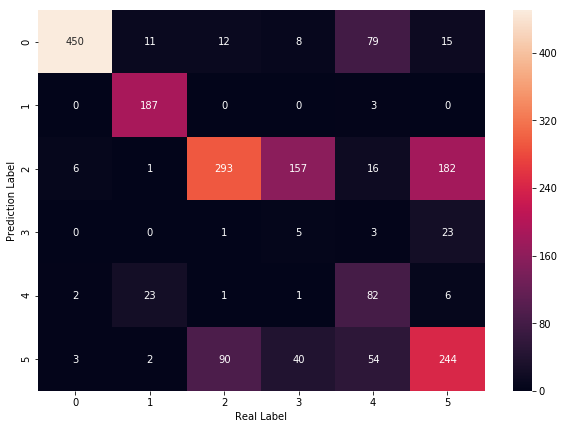

In [11]:
import seaborn as sn

df_cm = pd.DataFrame(cm, index = [i for i in "012345"],
                  columns = [i for i in "012345"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='.20g', annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()

In [12]:
def get_pred_train(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(6)]
    class1, class2 = classes[i]
    
    class1_indexes = []
    class2_indexes = []
    
    test_X = X[j]
    test_y = y[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i == class1:
            class1_indexes.extend(digits_indexes[i])
        elif i == class2:
            class2_indexes.extend(digits_indexes[i])

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    
    
    return pred_outputs

In [13]:
# 这里反而pred-outputs 的0 是第二类(id是1)，1是第一类（id是0）
pred_value = []

for j in range(4435):
    pred = []
    vote = [0,0,0,0,0,0]
    for i in range(15):
        pred_outputs = get_pred_train(i, j)
        #print(i,classes[i],pred_outputs[0][0])
        vote_for = classes[i][1 - pred_outputs[0]]
        vote[vote_for] += 1 #1 is class 1(id:0) and 0 is class 2(id:1)
    pred_value.append(np.where(vote==np.max(vote)))        
    #print(np.array(pred).T)
from random import randint
list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
train_acc = np.sum(list_P == y)/4435
print("Train Accuracy:{}".format(train_acc))

Train Accuracy:0.6356257046223225


In [14]:
winner_fitness = []
for winner in winner_list:
    #print(winner.fitness)
    winner_fitness.append(winner.fitness)
avg_train_acc = np.mean(winner_fitness)
print("Avg Train Accuracy:{}".format(avg_train_acc))

Avg Train Accuracy:0.8547062877921656


In [15]:
# program to check if there is exist a path between two vertices 
# of a graph 

from collections import defaultdict 

#This class represents a directed graph using adjacency list representation 
class Graph: 

	def __init__(self,vertices): 
		self.V= vertices #No. of vertices 
		self.graph = defaultdict(list) # default dictionary to store graph 

	# function to add an edge to graph 
	def addEdge(self,u,v): 
		self.graph[u].append(v) 
	
	# Use BFS to check path between s and d 
	def isReachable(self, s, d): 
		# Mark all the vertices as not visited 
		visited =[False]*(self.V) 

		# Create a queue for BFS 
		queue=[] 

		# Mark the source node as visited and enqueue it 
		queue.append(s) 
		visited[s] = True

		while queue: 

			#Dequeue a vertex from queue 
			n = queue.pop(0) 
			
			# If this adjacent node is the destination node, 
			# then return true 
			if n == d: 
				return True

			# Else, continue to do BFS 
			for i in self.graph[n]: 
				if visited[i] == False: 
					queue.append(i) 
					visited[i] = True
		# If BFS is complete without visited d 
		return False
    
    
def findAllPath(graph,start,end,path=[]):
    path = path +[start]
    if start == end:
        return [path]
 
    paths = [] #存储所有路径    
    for node in graph[start]:
        if node not in path:
            newpaths = findAllPath(graph,node,end,path) 
            for newpath in newpaths:
                paths.append(newpath)
    return paths

numbers = [*range(2)]
number_of_classification = len(numbers)

list_nodes_number = []
list_connection_number = []

for winner in winner_list:
    used_nodes = list(winner.nodes.keys())
    # create a dict for mapping 
    l1 = numbers + config.genome_config.input_keys + used_nodes[number_of_classification:]
    l2 = range(len(l1))
    dict_nodes = dict(zip(l1, l2))

    ### 将节点加入图
    g = Graph(len(l1))# inputs + outputs + used  
    # add connections in the graph
    for cg in winner.connections.values():
        if cg.enabled:
            g.addEdge(dict_nodes[cg.key[0]],dict_nodes[cg.key[1]])

    v = numbers
    list_connections = []
    for vi in v:
        for u in range(number_of_classification, len(config.genome_config.input_keys) + number_of_classification):
            list_connections.append(g.isReachable(u, vi))

    nodes_inputs = range(number_of_classification, number_of_classification+ 64)
    nodes_outputs = range(number_of_classification)
    nodes_mid = range(number_of_classification + 64, len(dict_nodes))

    # 找到所有输入和输出连接的路
    all_path = []
    for u in nodes_inputs:
        for v in nodes_outputs:
            path = findAllPath(g.graph, u, v)
            if path:
                all_path = all_path + path

    # 得到最长路，以及每个节点在哪个层级
    max_length = max([len(x) for x in all_path])
    nodes_tuples_list = []
    for path in all_path:
        #print(path)
        for node in path:
            nodes_tuples_list.append([node, path.index(node)])

    # 确定节点的层级（消除重复）       
    nodes_tuples_fixed_list = []
    for index in range(max_length):
        for nodes in nodes_tuples_list:
            node, node_index = nodes[0], nodes[1]
            if node_index == index: 
                if nodes not in nodes_tuples_fixed_list:
                    nodes_tuples_fixed_list.append(nodes)


    # 所有有连接的节点
    all_used_nodes = []
    for node in nodes_tuples_fixed_list:
        if node[0] not in all_used_nodes:
            all_used_nodes.append(node[0])

    # 确定节点的层级（最终确定）
    nodes_tuples_fixed_list_final = []

    for node in all_used_nodes:
        if node in nodes_inputs:
            nodes_tuples_fixed_list_final.append([node, 0])
        elif node in nodes_outputs:
            nodes_tuples_fixed_list_final.append([node, max_length - 1])
        else:
            list_node = []
            for nodes in nodes_tuples_fixed_list:
                if node == nodes[0]:
                    list_node.append(nodes)
            layer = 0
            for ele in list_node:
                # 删除重复项，取最大
                if ele[1] > layer:
                    layer = ele[1]
            nodes_tuples_fixed_list_final.append([node,layer])


    # 每个层级的节点合数
    length_of_layers = []
    number_of_nodes = 0
    for index in range(max_length):
        for nodes in nodes_tuples_fixed_list_final:
            node, node_index = nodes[0], nodes[1]
            if node_index == index: 
                number_of_nodes += 1
        length_of_layers.append(number_of_nodes)

    length_of_each_layer = []
    length_of_each_layer.append(length_of_layers[0])
    for i in range(1, max_length):
        length_of_each_layer.append(length_of_layers[i] - length_of_layers[i-1])

    # 输出每个层级的节点个数
    #print("length of each layers:", length_of_each_layer)

    # 所有端到端的路
    all_path_side2side = []
    for path in all_path:
        if len(path) == 2:
            all_path_side2side.append(path)
        else:
            for i in range(len(path)-1):
                all_path_side2side.append([path[i],path[i+1]])

    # 定义节点到绘图的字典
    dict_nodes_graph = dict()
    count_number_layer = [0] * max_length
    for nodes in nodes_tuples_fixed_list_final:
        node, layer = nodes
        dict_nodes_graph[node] = [count_number_layer[layer], layer]
        count_number_layer[layer] += 1
    list_nodes_number.append(np.sum(length_of_each_layer))
    list_connection_number.append(len(all_path_side2side))
    #print("Number of nodes:{} Number of connections:{}".format(np.sum(length_of_each_layer),len(all_path_side2side)))
total_nodes = np.sum(list_nodes_number)
total_connections = np.sum(list_connection_number)
print("Total nodes:{} Total connections::{}".format(total_nodes, total_connections))

Total nodes:130 Total connections::105


In [24]:
with open("ovo1.txt","w") as f:
    for item in [avg_train_acc, train_acc, test_acc, total_nodes, total_connections]:
        f.write(str(item)+'\n')